# Lab 05: Motion correction and slice timing

The purpose of this lab is to practice correcting for volume-to-volume motion in a functional image series, and to learn about common correction parameters and how to describe them with numbers and figures. We will also practice slice-timing correction, and test its effect on the timeseries data. 

## Preparation
* Import python tools for plotting
* Copy functional image from lab 01 into our working directory

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nilearn import plotting
from nilearn import image

In [3]:
%%bash

cp ../01-Lab/osfshare/sub-97_task-flanker_bold.nii.gz my_bold.nii.gz

## Describing and detecting motion with FSL tools

FSL offers a tool to detect motion outliers and to visually inspect motion and related changes in BOLD signal intensity
* [FSL Motion Outliers](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FSLMotionOutliers)
* This will create a dummy variable that codes for volumes possibly corrupted by motion, which can be used to ignore those volumes in our functional image analysis later. 

In [4]:
%%bash

# Running the bare bones command like below will output only the confound matrix 
# The default metric for detecting outliers is refrms (root mean square intensity diffs with referece vol, which is middle volume)
fsl_motion_outliers -i my_bold.nii.gz -o my_bold_motion 

In [6]:
%%bash
cat my_bold_motion

0   0   0   0   0   0   0   0   0   0   0   0  
1   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   

In [44]:
confound_mat=pd.read_table('my_bold_motion',header=None)

# How to plot like a design matrix output in the denoise py script?

In [14]:
%%bash

# We can produce figures of the motion by adding the -p flag
fsl_motion_outliers -i my_bold.nii.gz -o my_bold_motion -s refrms_ts -p refrms_plot

![refrms](refrms_plot.png)

In [13]:
%%bash

# This version of the command will use fd as the metric for detecting outliers
fsl_motion_outliers -i my_bold.nii.gz -o my_bold_motion --fd -s fd_ts -p fd_plot

![fd](fd_plot.png)

In [9]:
%%bash

# This version of the command will use dvars as the metric for detecting outliers
fsl_motion_outliers -i my_bold.nii.gz -o my_bold_motion --dvars -s dvars_ts -p dvars_plot

![dvars](dvars_plot.png)

In [30]:
dvars=pd.read_table('refrms_ts',header=None)

In [37]:
# Preview top values
dvars.head()

,0
0,0.000000
1,0.010767
2,0.000782
3,0.001384
4,0.001283


In [38]:
# Descriptives
dvars.describe()

,0
count,315.000000
mean,0.002674
std,0.002771
min,0.000000
25%,0.000982
50%,0.002067
75%,0.003539
max,0.021370


In [39]:
dvars.mean()

0    0.002674
dtype: float64

### Practice: what is the mean fd ?

In [40]:
# Python code
fd=pd.read_table('fd_ts',header=None)
fd.describe()

,0
count,315.000000
mean,0.101543
std,0.063065
min,0.000000
25%,0.064398
50%,0.099239
75%,0.125806
max,0.687702


## Motion correction tools in FSL

mcflirt is the basic motion correction tool provided by FSL
* [User guide](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/MCFLIRT)

In [46]:
%%bash

# Look at usage for mcflirt
mcflirt

Usage: mcflirt -in <infile> [options]

  Available options are:
        -out, -o <outfile>               (default is infile_mcf)
        -cost {mutualinfo,woods,corratio,normcorr,normmi,leastsquares}        (default is normcorr)
        -bins <number of histogram bins>   (default is 256)
        -dof  <number of transform dofs>   (default is 6)
        -refvol <number of reference volume> (default is no_vols/2)- registers to (n+1)th volume in series
        -reffile, -r <filename>            use a separate 3d image file as the target for registration (overrides refvol option)
        -scaling <num>                             (6.0 is default)
        -smooth <num>                      (1.0 is default - controls smoothing in cost function)
        -rotation <num>                    specify scaling factor for rotation optimization tolerances
        -verbose <num>                     (0 is least and default)
        -stages <number of search levels>  (default is 3 - specify 4 for final s

In [47]:
%%bash

# Example mcflirt call with defaults
# Input does not have to be skull stripped
# Default cost function is normalized correlation

mcflirt -in my_bold \
-out my_bold_mcf \
-cost normcorr \
-refvol 157 \
-mats -plots \
-rmsrel -rmsabs -spline_final 

Notes about mcflirt
* mats gives us a directory of .mat files, what do these represent?
* {out}.par is a text file with 6 columes, the first three columns are rotations for x,y,z and last three are translations for x,y,z
* Informative [old post](https://www.jiscmail.ac.uk/cgi-bin/webadmin?A2=fsl;cda6e2ea.1112) about the relation between the .MAT files and the .par parameters

In [50]:
!cat my_bold_mcf.par

-0.00235365  -0.00268918  -0.00123003  -0.189328  -0.0381569  -0.103865  
-0.00193801  -0.00268918  -0.00136075  -0.203558  -0.081004  -0.00842706  
-0.00276387  -0.00263573  -0.0013004  -0.208256  0.000850255  0.0110615  
-0.00261557  -0.00268918  -0.00152084  -0.210206  -0.0885671  0.0384276  
-0.00261557  -0.00245883  -0.0013004  -0.199139  -0.0546978  0.0337166  
-0.00266724  -0.00269256  -0.00119302  -0.180762  -0.0313508  0.0452187  
-0.00255521  -0.00228903  -0.0013004  -0.197748  -0.0923565  0.0642676  
-0.00271359  -0.00228903  -0.0013004  -0.195086  -0.0483549  0.0799969  
-0.00276466  -0.00248933  -0.00118778  -0.198487  -0.0296003  0.0568272  
-0.00234539  -0.00228903  -0.0013004  -0.196536  -0.0883617  0.0794092  
-0.00308568  -0.00258971  -0.0011868  -0.195505  -0.036652  0.0688867  
-0.00282853  -0.00228903  -0.0013004  -0.188303  -0.0363468  0.066053  
-0.00287632  -0.00246737  -0.0013004  -0.194856  -0.0803842  0.0817202  
-0.00304057  -0.00228903  -0.0013004  -0.20222

In [52]:
%%bash

# FSL has a simple plotting command for timeseries data
fsl_tsplot

***************************************************
The following COMPULSORY options have not been set:
	-i,--in	        comma-separated list of input file names (ASCII text matrix, one column per timecourse)
	-o,--out	output filename for the PNG file
***************************************************

Part of FSL (build 509)
fsl_tsplot 
Copyright(c) 2007, University of Oxford (Christian F. Beckmann)

Usage: 
fsl_tsplot [options] 

Compulsory arguments (You MUST set one or more of):
	-i,--in	        comma-separated list of input file names (ASCII text matrix, one column per timecourse)
	-o,--out	output filename for the PNG file

Optional arguments (You may optionally specify one or more of):
	-t,--title	plot title
	-l,--legend	file name of ASCII text file, one row per legend entry
	-a,--labels	comma-separated list of labels
	--ymin	        minimum y-value
	--ymax	        maximum y-value
	-x,--xlabel	X-axis label
	-y,--ylabel	Y-axis label
	-h,--height	plot height in pixels (default 150

In [53]:
%%bash

# Plot rotations (radians)
fsl_tsplot -i my_bold_mcf.par \
-t 'MCFLIRT estimated rotations (radians)' \
-u 1 --start=1 --finish=3 -a x,y,z -w 640 -h 144 -o rot.png 

![rotations](rot.png)

In [54]:
%%bash

# Plot translations (mm)
fsl_tsplot -i my_bold_mcf.par \
-t 'MCFLIRT estimated translations (mm)' \
-u 1 --start=4 --finish=6 -a x,y,z -w 640 -h 144 -o trans.png 

![trans](trans.png)

In [58]:
%%bash

# Plot displacement. Abs=relative to reference vol. Rel=relative to vol n-1.
fsl_tsplot -i my_bold_mcf_abs.rms,my_bold_mcf_rel.rms \
-t 'MCFLIRT estimated mean displacement (mm)' \
-u 1 -w 640 -h 144 -a absolute,relative -o disp.png 

![disp](disp.png)

Compare to fd and dvars:
![fd](fd_plot.png)
![dvars](dvars_plot.png)

In [85]:
%%bash

# Let's compare our functional volume from before to after motion correction in FSLview
fslview

In [63]:
%%bash

# Did we get rid of ALL frame wise displacement?
fsl_motion_outliers -i my_bold_mcf.nii.gz -o my_bold_motion_mcf --fd -s fd_mcf_ts -p fd_mcf_plot

In [64]:
fd_mcf=pd.read_table('fd_mcf_ts',header=None)
fd_mcf.describe()

,0
count,315.000000
mean,0.036145
std,0.019491
min,0.000000
25%,0.023967
50%,0.033404
75%,0.046033
max,0.206893


![fd_mcf](fd_mcf_plot.png)

## Slice timing correction in FSL

In [60]:
%%bash

# Usage
slicetimer

***************************************************
The following COMPULSORY options have not been set:
	-i,--in	filename of input timeseries
***************************************************

Part of FSL (build 509)
slicetimer 
FMRIB's Interpolation for Slice Timing
Copyright(c) 2001-2009, University of Oxford

Usage: 
slicetimer -i <timeseries> [-o <corrected_timeseries>] [options]


Compulsory arguments (You MUST set one or more of):
	-i,--in	filename of input timeseries

Optional arguments (You may optionally specify one or more of):
	-o,--out	filename of output timeseries
	-h,--help	display this message
	-v,--verbose	switch on diagnostic messages
	--down	reverse slice indexing (default is: slices were acquired bottom-up)
	-r,--repeat	Specify TR of data - default is 3s
	-d,--direction	direction of slice acquisition (x=1,y=2,z=3) - default is z
	--odd	use interleaved acquisition
	--tcustom	filename of single-column slice timings, in fractions of TR, +ve values shift slices forward

In [61]:
%%bash

slicetimer -i my_bold_mcf.nii.gz \
-r 2 \
-o my_bold_mcf_st.nii.gz

In [65]:
%%bash

fslview

In [77]:
%%bash

fslmeants -i my_bold_mcf.nii.gz -o mcf_right_mot_ts.txt -m my_bold_right_mot_mask.nii.gz
fslmeants -i my_bold_mcf_st.nii.gz -o mcf_st_right_mot_ts.txt -m my_bold_right_mot_mask.nii.gz
fslmeants -i my_bold_mcf.nii.gz -o mcf_right_hip_ts.txt -m my_bold_right_hip_mask.nii.gz
fslmeants -i my_bold_mcf_st.nii.gz -o mcf_st_right_hip_ts.txt -m my_bold_right_hip_mask.nii.gz

In [79]:
mcf_mot = pd.read_table('mcf_right_mot_ts.txt', header=None)
mcf_hip = pd.read_table('mcf_right_hip_ts.txt', header=None)
mcf_st_mot = pd.read_table('mcf_st_right_mot_ts.txt', header=None)
mcf_st_hip = pd.read_table('mcf_st_right_hip_ts.txt', header=None)

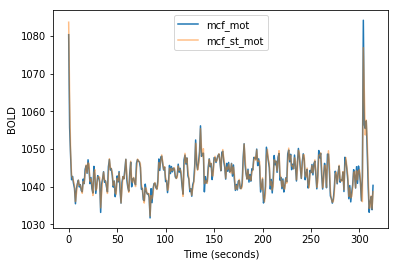

In [84]:
plt.plot(mcf_mot,label='mcf_mot') #plot the variable
plt.plot(mcf_st_mot,label='mcf_st_mot',alpha=.5)
plt.xlabel('Time (seconds)')
plt.ylabel('BOLD')
plt.legend(loc='best')

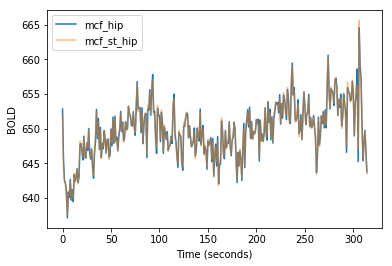

In [83]:
plt.plot(mcf_hip,label='mcf_hip') #plot the variable
plt.plot(mcf_st_hip,label='mcf_st_hip',alpha=.5)
plt.xlabel('Time (seconds)')
plt.ylabel('BOLD')
plt.legend(loc='best')

### What if we did slice timing correction first?

Work together to now run slice timing first following by motion correction, and compare final estimate of FD with a plot.
* Name your slice-time corrected image my_bold_st.nii.gz
* Name your slice-time corrected + motion corrected image my_bold_st_mcf.nii.gz

In [86]:
%%bash

# slice-timing on the raw bold
slicetimer -i my_bold.nii.gz \
-r 2 \
-o my_bold_st.nii.gz

# motion correction on st image
mcflirt -in my_bold_st \
-out my_bold_st_mcf \
-cost normcorr \
-refvol 157 \
-mats -plots \
-rmsrel -rmsabs -spline_final

In [87]:
!ls

disp.png				  my_bold_mcf_st.nii.gz
dvars_plot.png				  my_bold_motion
dvars_ts				  my_bold_motion_mcf
fd_mcf_plot.png				  my_bold.nii.gz
fd_mcf_ts				  my_bold_right_hip_mask.nii.gz
fd_plot.png				  my_bold_right_mot_mask.nii.gz
fd_ts					  my_bold_st_mcf_abs_mean.rms
mcf_right_hip_ts.txt			  my_bold_st_mcf_abs.rms
mcf_right_mot_ts.txt			  my_bold_st_mcf.mat
mcf_st_right_hip_ts.txt			  my_bold_st_mcf.nii.gz
mcf_st_right_mot_ts.txt			  my_bold_st_mcf.par
Motion correction and slice timing.ipynb  my_bold_st_mcf_rel_mean.rms
my_bold_mcf_abs_mean.rms		  my_bold_st_mcf_rel.rms
my_bold_mcf_abs.rms			  my_bold_st.nii.gz
my_bold_mcf.mat				  refrms_plot.png
my_bold_mcf.nii.gz			  refrms_ts
my_bold_mcf.par				  rot.png
my_bold_mcf_rel_mean.rms		  trans.png
my_bold_mcf_rel.rms


In [92]:
%%bash

fsl_motion_outliers -i my_bold_st.nii.gz -o my_bold_st_motion --fd -s fd_st_ts -p fd_st_plot

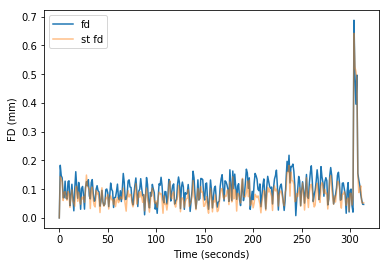

In [93]:
fd = pd.read_table('fd_ts', header=None)
fd_st = pd.read_table('fd_st_ts', header=None)
plt.plot(fd,label='fd')
plt.plot(fd_st,label='st fd',alpha=.5)

plt.xlabel('Time (seconds)')
plt.ylabel('FD (mm)')
plt.legend(loc='best')

In [94]:
fd_st=pd.read_table('fd_st_ts',header=None)
fd_st.describe()

,0
count,315.000000
mean,0.081352
std,0.060621
min,0.000000
25%,0.055005
50%,0.074016
75%,0.093416
max,0.642418
